In [29]:
import os
import cv2
import time
import torch
import scipy.signal
import math as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Funciones

This function simulates the propagation of light through an f-f system: a portion of free space of thickness f, a lens of focal length f>0, and a second portion of free space of thickness f.

In [30]:
def function_lens(field1, pixel, f, wavelength):

    if f < 0:
        field2 = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(field1)))
    else:
        field2 = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(field1)))

    NX, NY = field1.shape
    psX = abs(f * wavelength / (NX * pixel))
    psY = abs(f * wavelength / (NY * pixel))

    return field2, psX, psY

# Function_propagate

Esta función simula la propagación paraxial de un campo complejo 2D
Entradas:

- field1 = campo complejo (amplitud .* exp(i*phase)) en z=0,
- psx = tamaño de píxel a lo largo del eje x
- psy = tamaño de píxel a lo largo del eje y
- longitud de onda
- z = distancia de propagación deseada

Salidas:
- field2 = el campo complejo en la distancia z

In [31]:
def function_propagate(field1, wavelength, z, psx, psy):

    M, N = field1.shape
    if M % 2 == 1:
        UY = np.arange(1, M + 1) - np.mean(np.arange(1, M + 1)) - 1
    else:
        UY = np.arange(1, M + 1) - np.mean(np.arange(1, M + 1)) - 0.5

    if N % 2 == 1:
        UX = np.arange(1, N + 1) - np.mean(np.arange(1, N + 1)) - 1
    else:
        UX = np.arange(1, N + 1) - np.mean(np.arange(1, N + 1)) - 0.5

    x, y = np.meshgrid(UX, UY)
    
    kx = x / (psx * N)
    ky = y / (psy * M)

    H = np.exp(-1j * np.pi * wavelength * z * (kx**2 + ky**2))
    H = np.fft.fftshift(H)
    objFT = np.fft.fft2(field1)
    field2 = np.fft.ifft2(objFT * H)
    
    return field2

# function_GS_Z

Implementación del algoritmo Gerchberg-Saxton para optimizar patrones de modulación de onda coherente

Entradas: 
- target_amplitude = distribución de intensidad 3D objetivo
- N = número de iteraciones
- z = ubicación del objetivo a lo largo del plano z

Salidas:
- DMDPattern = un patrón DMD optimizado

    laser_amplitude = np.exp(-((XX ** 2 + YY ** 2) / Setup.laserradius ** 2))
    FieldB = laser_amplitude * np.exp(1j * 2 * np.pi * np.random.rand(Setup.DMDX, Setup.DMDY))
    FieldA, psx, psy = function_lens(FieldB, Setup.ps, Setup.ps, Setup.f, Setup.lambda)
    URX = psx * (np.arange(1, Setup.DMDX + 1) - np.mean(np.arange(1, Setup.DMDX + 1)))
    URY = psy * (np.arange(1, Setup.DMDY + 1) - np.mean(np.arange(1, Setup.DMDY + 1)))
    RXX, RYY = np.meshgrid(URX, URY)

In [32]:
def function_GS_Z(resolution, N, z, target):
    global FieldA, FieldB
    # Inicializar con amplitud deseada y fase aleatoria
    FieldZ = target * np.exp(1j * 2 * np.pi * np.random.rand(resolution[0], resolution[1]))
    mask = np.double(np.sqrt(XX ** 2 + YY ** 2) < 0.00001)
    FieldB = laser_amplitude * np.exp(1j * 2 * np.pi * np.random.rand(resolution[0], resolution[1]))
    # Iteración
    for i in range(N):
        # Propagar desde z=0 hasta plano DMD
        FieldA, _, _ = function_lens(FieldB, pixel, focal_distance, wavelength)
        
        # Umbral en el valor medio para llenar aproximadamente la mitad del DMD
        Amplitude = np.abs(FieldA)
        DMDPattern = np.double(Amplitude > (np.median(Amplitude)))
        FieldA = laser_amplitude * DMDPattern

        # Regresar al plano de imagen
        FieldB, psx, psy = function_lens(FieldA, pixel, - focal_distance, wavelength)

        # Normalizar FieldB
        FieldB = FieldB / np.sqrt(np.sum(np.abs(FieldB) ** 2))
        EnergyinSignal = np.sum(np.abs((1 - mask) * FieldB) ** 2)

        # Propagar desde z=0 a z y propagar solo la señal
        fieldZ = function_propagate((1 - mask) * FieldB, wavelength, z, psy, psx)

        # Actualizar amplitud
        fieldZ = np.sqrt(EnergyinSignal) * target * np.exp(1j * np.angle(fieldZ))

        # Propagar desde z a z=0 y propagar solo la señal
        fieldNB = function_propagate(fieldZ, wavelength, - z, psy, psx)

        # Agregar el término DC nuevamente en z=0
        FieldB = (mask) * FieldB + (1 - mask) * fieldNB

    return DMDPattern

# Function Rendering

Genera imágenes a una distancia específica (z) a partir de patrones almacenados en un dispositivo de modulación digital de microespejos (DMD)

Inputs:
- z = an array of size LZ corresponding to the propagation distance of the image depth planes
- DMDPatterns = a set of p DMD patterns of size LX, LY, p

Outputs:
- VolumeImage = A stack of intensity data corresponding to individually propagated coherent waves, of size
- LX, LY, LZ, p

In [33]:
def function_Rendering(pixel, resolution, focal_distance, wavelength, z, DMDPatterns):
    LX, LY, LP = DMDPatterns.shape

    VolumeImage = np.zeros((resolution[0], resolution[1], LP))
    
    for k in range(LP):
        FieldA = laser_amplitude * DMDPatterns[:, :, k]

        # go to image plane
        FieldB, psx, psy = function_lens(FieldA, pixel, - focal_distance, wavelength)

        FieldB = FieldB / np.sqrt(np.sum(np.abs(FieldB)**2))

        fieldZ = function_propagate((1 - mask) * FieldB, wavelength, z, psy, psx)
        fieldZ = fieldZ / np.sqrt(np.sum(np.abs(fieldZ)**2))
        
        VolumeImage[:, :, k] = np.abs(fieldZ**2)

    return VolumeImage

# Function_accuracy
accuracy is a measure of mismatch between A and B.

In [34]:
def function_accuracy(A, B):

    prod = A * B
    accuracy = np.sum(prod) / np.sqrt(np.sum(A**2) * np.sum(B**2))
    return accuracy

# Function_GS_Z3D_inc

This is a core step of the DCGH - Gerchberg–Saxton algorithm to optimize several coherent wave modulation patterns at once.

Inputs:
- target_amplitude = target 3D intensity distribution
- z = location of target along the z plane
- DMDPatternref = an initial estimation of the DMDPattern to be optimized

Outputs:
- DMDPattern = the updated DMD pattern

In [35]:
def function_GS_Z3D_inc(focal_distance, wavelength, DMDPatterns, z, target):
    mask = np.sqrt(XX**2 + YY**2) < 0.0001

    FieldA = laser_amplitude * DMDPatterns

    # go back to image plane
    FieldB, psx, psy = function_lens(FieldA, pixel, - focal_distance, wavelength )

    FieldB = FieldB / np.sqrt(np.sum(np.abs(FieldB)**2))
    EnergyinSignal = np.sum(np.abs((1 - mask) * FieldB)**2)

    fieldNB = FieldB - FieldB

    # Go from zero to z propagate the signal only
    fieldZ = function_propagate((1 - mask) * FieldB, wavelength, z, psy, psx)

    # Update the amplitude
    fieldZ = np.sqrt(EnergyinSignal) * target[:, :] * np.exp(1j * np.angle(fieldZ))

    # Go from z to zero propagate the signal only
    fieldNB = fieldNB + function_propagate(fieldZ, wavelength, -z, psy, psx)

    fieldNB = fieldNB / np.sqrt(np.sum(np.abs(fieldNB)**2))

    # Add the DC term back at z=0
    FieldB = (mask) * FieldB + (1 - mask) * fieldNB
    # start in z=0 Go to DMD plane
    FieldA, _, _ = function_lens(FieldB, psx, focal_distance, wavelength)

    # Threshold at median value to fill about half the DMD
    Amplitude = np.abs(FieldA)
    DMDPattern = (Amplitude > (np.median(Amplitude)))

    return DMDPattern

# Variables y Parámetros

In [36]:
#______________________________________________VARIABLES DE ENTRADA DEL SISTEMA FÍSICO
wavelength = 635e-9
focal_distance = 0.5
radio_lente = 0.02
z = 0.8

#Radius of the gaussian laser spot on DMD
laserradius = 200e-4

#______________________________________________VARIABLES DEL DISPOSITIVO
pixel = 13.3e-6
resolution = [512, 512]

In [37]:
#Caracterización del láser
UX = pixel*np.arange(1,resolution[0]+1); UY = pixel*np.arange(1,resolution[1]+1)
UX = UX - np.mean(UX); UY = UY - np.mean(UY)

XX, YY = np.meshgrid(UX, UY)
laser_amplitude = np.exp(-((XX**2 + YY**2) / laserradius**2))

FieldB = laser_amplitude * np.exp(1j * 2 * np.pi * np.random.rand(resolution[0], resolution[1]))
FieldA, psx, psy = function_lens(FieldB,pixel,focal_distance,wavelength)

#Caracterización del DMD
URX = psx*np.arange(1,resolution[0]+1); URY = psy*np.arange(1,resolution[1]+1)
URX = URX-np.mean(URX); URY = URY-np.mean(URY)

#URX, URY límite de los ejes del espacio real
RXX, RYY = np.meshgrid(URX, URY)

#Creación de la máscara
mask = np.sqrt(XX**2 + YY**2) < 0.0001

In [38]:
from PIL import Image

target_intensity = np.array(Image.open('Target_Images/leon.jpg'))
target_amplitude = np.sqrt(np.mean(target_intensity, axis=2)).astype(float)
target_amplitude /= np.max(target_amplitude)
#target = np.concatenate((target_amplitude, np.rot90(np.rot90(target_amplitude))), axis=1)

#aquí tengo que hacer algo por si la imagen no es de pares
equis = (resolution[0] - target_amplitude.shape[0]) // 2
yes = (resolution[1] + 1 - target_amplitude.shape[1]) // 2

target_padded = np.pad(target_amplitude, ((equis, equis),(yes, yes)),
                                           mode='constant', constant_values=0)

target = np.zeros(target_padded[:, :].shape)
target[:, :] = np.squeeze(target_padded[:, :]) / np.sqrt(np.sum(np.abs(target_padded[:, :])**2))

In [39]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim
import scipy.io

N = [100]
P = [25]

for n in N:
    print('Para N = ', n)
    archivo_metricas = f"C:/Users/hdspl/OneDrive/Escritorio/HDSP/holografia/Articulo/Codigo/metricas{n}.xlsx"
    acuracy, acuracy2, psnr = [], [], []
    for p in P:    
        print('con ', p,'patrones')
        
        # Inicializa DMDPatterns
        DMDPatterns = np.zeros((resolution[0], resolution[1], p)) 

        for k in range(p):
            DMDPatterns[:,:,k] = function_GS_Z(resolution, n, z, target)
        
        VolumeImages = function_Rendering(pixel, resolution, focal_distance, wavelength, z, DMDPatterns)

        for i in range(n):

            # New target amplitude computation
            for k in range(p):
                newa = target - target
                baseintensity = target[:, :]**2
                    
                for q in range(p):
                    if q != k:
                        baseintensity -= VolumeImages[:, :, q] / p
                        
                newa[:, : ] = np.sqrt(np.maximum(baseintensity, 0))
                DMDPatterns[:, :, k] = function_GS_Z3D_inc(focal_distance, wavelength, DMDPatterns[:, :, k], z, newa)

            #Render images from DMD patterns
            VolumeImages = function_Rendering(pixel, resolution, focal_distance, wavelength, z, DMDPatterns)
        
        VolumeImageAV = np.mean(VolumeImages, axis=2)
        acuracy = np.append(acuracy , function_accuracy(VolumeImageAV, target**2))
        acuracy2 = np.append(acuracy2 , function_accuracy(VolumeImageAV, (1-target)**2))
        psnr = np.append(psnr , peak_signal_noise_ratio(target, VolumeImageAV))

        archivo_patrones = f"C:/Users/hdspl/OneDrive/Escritorio/HDSP/holografia/Articulo/Codigo/patrones{n}_{p}.xlsx"
        archivo_imagenes = f"C:/Users/hdspl/OneDrive/Escritorio/HDSP/holografia/Articulo/Codigo/imagenes{n}_{p}.xlsx"

        matriz_patrones = pd.DataFrame(DMDPatterns[:,:,0])
        matriz_patrones.to_excel(archivo_patrones, sheet_name='Sheet00', index=False)

        matriz_imagen = pd.DataFrame(VolumeImages[:,:,0])
        matriz_imagen.to_excel(archivo_imagenes, sheet_name='Sheet00', index=False)

        with pd.ExcelWriter(archivo_patrones, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
            for b in range(p):
                print('Ya se guardó el patrón: ', b)
                hoja = f'Sheet{b+1}'  # Nombre de la hoja
                #guardar los patrones
                matriz_patrones = pd.DataFrame(DMDPatterns[:,:,b])
                matriz_patrones.to_excel(archivo_patrones, sheet_name=hoja, index=False)
                matriz_patrones.to_excel(writer, sheet_name=hoja, index=False)

        with pd.ExcelWriter(archivo_imagenes, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
            for b in range(p):
                print('Ya se guardó la imagen: ', b)
                hoja = f'Sheet{b+1}'  # Nombre de la hoja
                #guardar los patrones
                matriz_imagen = pd.DataFrame(VolumeImages[:,:,b])
                matriz_imagen.to_excel(archivo_imagenes, sheet_name=hoja, index=False)
                matriz_imagen.to_excel(writer, sheet_name=hoja, index=False)
            
        if p % 5 == 0:
            metricas = pd.DataFrame({"acuracy":acuracy, "acuracy2":acuracy2, "psnr":psnr})
            metricas.to_excel(archivo_metricas, sheet_name='Sheet0', index=False)

            with pd.ExcelWriter(archivo_metricas, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
                metricas.to_excel(writer, sheet_name='Sheet0', index=False)

            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow(VolumeImageAV)
            plt.subplot(1,2,2)
            plt.imshow(DMDPatterns[:,:,0])
            plt.show()


Para N =  20
con  1 patrones


KeyboardInterrupt: 

Para N =  100
con  25 patrones


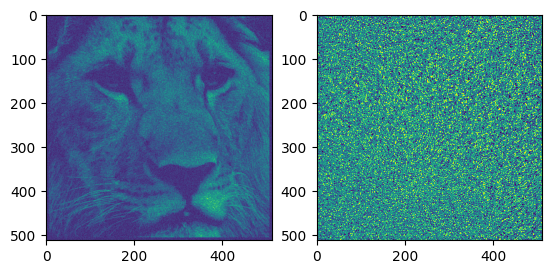

In [40]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim
import scipy.io

N = [100]
P = [25]

for n in N:
    print('Para N = ', n)
    archivo_metricas = f"C:/Users/hdspl/OneDrive/Escritorio/HDSP/holografia/Articulo/Codigo/metricas{n}.xlsx"
    acuracy, acuracy2, psnr = [], [], []
    for p in P:    
        print('con ', p,'patrones')
        
        # Inicializa DMDPatterns
        DMDPatterns = np.zeros((resolution[0], resolution[1], p)) 

        for k in range(p):
            DMDPatterns[:,:,k] = function_GS_Z(resolution, n, z, target)
        
        VolumeImages = function_Rendering(pixel, resolution, focal_distance, wavelength, z, DMDPatterns)

        for i in range(n):

            # New target amplitude computation
            for k in range(p):
                newa = target - target
                baseintensity = target[:, :]**2
                    
                for q in range(p):
                    if q != k:
                        baseintensity -= VolumeImages[:, :, q] / p
                        
                newa[:, : ] = np.sqrt(np.maximum(baseintensity, 0))
                DMDPatterns[:, :, k] = function_GS_Z3D_inc(focal_distance, wavelength, DMDPatterns[:, :, k], z, newa)

            #Render images from DMD patterns
            VolumeImages = function_Rendering(pixel, resolution, focal_distance, wavelength, z, DMDPatterns)
        
        VolumeImageAV = np.mean(VolumeImages, axis=2)
        acuracy = np.append(acuracy , function_accuracy(VolumeImageAV, target**2))
        acuracy2 = np.append(acuracy2 , function_accuracy(VolumeImageAV, (1-target)**2))
        psnr = np.append(psnr , peak_signal_noise_ratio(target, VolumeImageAV))
            
        if p % 5 == 0:
            metricas = pd.DataFrame({"acuracy":acuracy, "acuracy2":acuracy2, "psnr":psnr})
            metricas.to_excel(archivo_metricas, sheet_name='Sheet0', index=False)

            with pd.ExcelWriter(archivo_metricas, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
                metricas.to_excel(writer, sheet_name='Sheet0', index=False)

            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow(VolumeImageAV)
            plt.subplot(1,2,2)
            plt.imshow(DMDPatterns[:,:,0])
            plt.show()

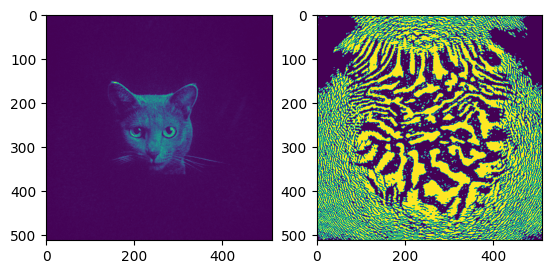

In [ ]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(VolumeImageAV)
plt.subplot(1,2,2)
plt.imshow(DMDPatterns[:,:,0])
plt.show()

In [ ]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim
import scipy.io

archivo_metricas = "C:/Users/hdspl/OneDrive/Escritorio/HDSP/holografia/Articulo/Codigo/metricas.xlsx"
archivo_patrones = "C:/Users/hdspl/OneDrive/Escritorio/HDSP/holografia/Articulo/Codigo/patrones.xlsx"
archivo_imagenes = "C:/Users/hdspl/OneDrive/Escritorio/HDSP/holografia/Articulo/Codigo/imagenes.xlsx"

N = 200
P = [1,2,3,4,5,6,7,8,9,10]
acuracy = []
Imagenes = []
psnr = []

for p in P:    
    print(p)
    DMDPatterns = np.zeros((resolution[0], resolution[1], p)) # Inicializa DMDPatterns

    for k in range(p):
        DMDPatterns[:,:,k] = function_GS_Z(resolution, N, z, target)
    
    VolumeImages = function_Rendering(pixel, resolution, focal_distance, wavelength, z, DMDPatterns)

    for i in range(N):

        # New target amplitude computation
        for k in range(p):
            newa = target - target
            baseintensity = target[:, :]**2
                
            for q in range(p):
                if q != k:
                    baseintensity -= VolumeImages[:, :, q] / p
                    
            newa[:, : ] = np.sqrt(np.maximum(baseintensity, 0))
            DMDPatterns[:, :, k] = function_GS_Z3D_inc(focal_distance, wavelength, DMDPatterns[:, :, k], z, newa)

        #Render images from DMD patterns
        VolumeImages = function_Rendering(pixel, resolution, focal_distance, wavelength, z, DMDPatterns)
    
    VolumeImageAV = np.mean(VolumeImages, axis=2)
    Imagenes = np.append(Imagenes , VolumeImageAV)
    acuracy = np.append(acuracy , function_accuracy(VolumeImageAV, target**2))
    psnr = np.append(psnr , peak_signal_noise_ratio(target, VolumeImageAV))

    for n in range(p):
        
        hoja = f'Sheet{n}'  # Nombre de la hoja
        dataimf = pd.DataFrame({"acuracy":acuracy, "psnr":psnr})
        dataimg.to_excel(nombre_archivo, sheet_name=hoja, index=False)

        with pd.ExcelWriter(nombre_archivo, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
            df.to_excel(writer, sheet_name=hoja, index=False)

        datapatrones = pd.DataFrame({"acuracy":acuracy, "psnr":psnr})
        datapatrones .to_excel(nombre_archivo, sheet_name=hoja, index=False)

        with pd.ExcelWriter(nombre_archivo, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
            df.to_excel(writer, sheet_name=hoja, index=False)


    if p % 5 == 0:

        df = pd.DataFrame({"acuracy":acuracy, "psnr":psnr})
        df.to_excel(nombre_archivo, sheet_name=hoja, index=False)

        with pd.ExcelWriter(nombre_archivo, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
            df.to_excel(writer, sheet_name=hoja, index=False)

        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(VolumeImageAV)
        plt.subplot(1,2,2)
        plt.imshow(DMDPatterns[:,:,0])
        plt.show()


1


NameError: name 'dataimg' is not defined

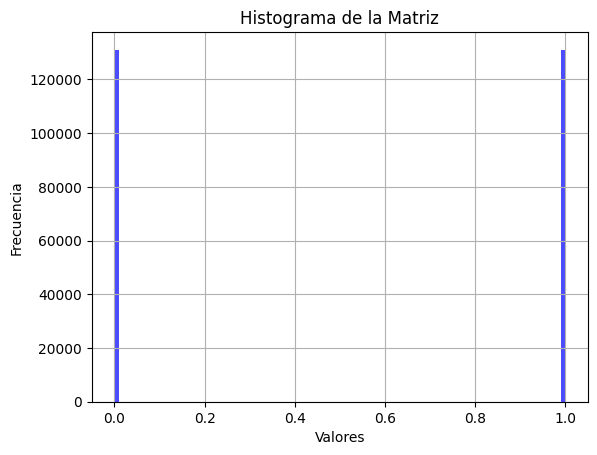

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Crear un histograma de la matriz
plt.hist(DMDPatterns[:,:,0].ravel(), bins=100, color='blue', alpha=0.7)
plt.title('Histograma de la Matriz')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.grid(True)

# Mostrar el histograma
plt.show()


NameError: name 'ejeY1' is not defined

<Figure size 640x480 with 0 Axes>

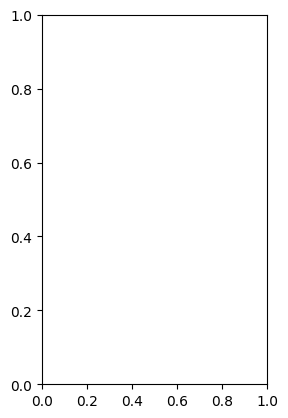

In [ ]:
#Grafica
f = plt.figure(1)
plt.figure()
plt.subplot(1,2,1)
plt.scatter(P, ejeY1[0])
plt.title('Accuracy per iteration')
plt.ylabel('Accuracy  [A.U.]')
plt.xlabel('Cantidad de Patrones')

plt.subplot(1,2,2)
plt.scatter(P, ejeY2[0])
plt.title('Accuracy per iteration')
plt.ylabel('Accuracy  [A.U.]')
plt.xlabel('Cantidad de Patrones')
plt.show()

In [ ]:
#Grafica
f = plt.figure(1)
plt.figure())
plt.subplot(1,2,1)
plt.scatter(P, ejeY1[0])
plt.title('Accuracy per iteration')
plt.ylabel('Accuracy  [A.U.]')
plt.xlabel('Cantidad de Patrones')

plt.subplot(1,2,2)
plt.scatter(P, ejeY2[0])
plt.title('Accuracy per iteration')
plt.ylabel('Accuracy  [A.U.]')
plt.xlabel('Cantidad de Patrones')
plt.show()

SyntaxError: unmatched ')' (486429142.py, line 3)

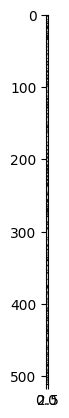

In [ ]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(DMDPatterns[0])
plt.show()